# Similar to `simulated_pendulum.ipynb`, this script's purpose is to analyze the readings from the accelerometer/gyroscope. 
# The difference is that this one should be able to use real data, not simulated data. So far it only attempts to fit gyroscopic acceleration in the z-direction and linear acceleration in the x-direction.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [2]:
# TODO: add damping term for x-acceleration
# todo: convert bit reading into quantities with proper units
# todo: add more fits
path = input('file name (type "def" to use default): ')
if path == 'def':
    path = 'AccelGyro Test.txt'

file name (type "def" to use default): def


In [3]:
all_data = np.genfromtxt(path, delimiter = '\t') 
# turn all the data into numpy arrays
# there is likely a much faster way to do this but I don't care (yet)
count = all_data[:,0]
timestamp = all_data[:,1]
temp = all_data[:,2]
x_accel = all_data[:,3]
y_accel = all_data[:,4]
z_accel = all_data[:,5]
x_gyro = all_data[:,6]
y_gyro = all_data[:,7]
z_gyro = all_data[:,8]

## The hardest part of the fitting is the guessing. You might have to run it many times, manually adjusting these parameters every time.

In [4]:
# parameter guesses
THETA_0 = np.radians(float(input('initial angle guess (deg): ')))
k_guess = float(input('k-factor guess (for linear damping): '))
frequency = float(input('guess angular frequency: '))

# constants: 
g = 9.80

initial angle guess (deg): 5
k-factor guess (for linear damping): .5
guess angular frequency: 3.8


In [5]:
# define functions designed for scipy's curve fit that can guess omega

def x_accel_to_fit(t, frq, theta_init):
    # optimizes fit for linear acceleration in the x-direction by changing theta and omega
    return g*np.cos(theta_init * np.cos(frq * t)) + np.average(x_accel) # add mean for better fit

def theta_accel(t, omega, k_factor):
    # optimizes the fit gyroscopic acceleration by changing omega and k
    return -THETA_0 * omega**2 * np.cos(omega*t) * np.exp(-k_factor * t) + np.average(z_gyro) # add mean for better fit


In [6]:
# this is where the actual fitting begins
parameters0 = [frequency, THETA_0]
parameters1 = [frequency, k_guess]

# popt is the list of optimal parameters, as determined by curve_fit
# pcov is the covariance matrix, whose diagonal entries are the variance of each parameter
popt0, pcov0 = curve_fit(x_accel_to_fit, timestamp, x_accel, parameters0)
popt1, pcov1 = curve_fit(theta_accel, timestamp, z_gyro, parameters1)

<ipython-input-5-c98d5ead01f4>:9: RuntimeWarning: overflow encountered in exp
  return -THETA_0 * omega**2 * np.cos(omega*t) * np.exp(-k_factor * t) + np.average(z_gyro) # add mean for better fit
c:\users\mhanr\appdata\local\programs\python\python39\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Text(0, 0.5, 'Gyroscopic Acceleration (bits)')

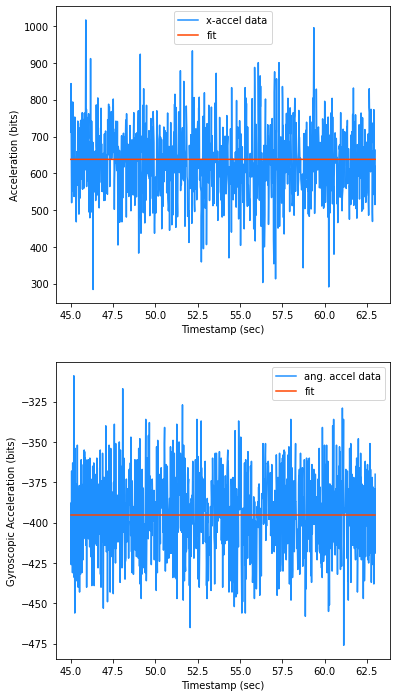

In [7]:
accel_fit = x_accel_to_fit(timestamp, *parameters0)
rad_accel_fit = theta_accel(timestamp, *parameters1)
fig, ax = plt.subplots(2,1, figsize = (6,12))
ax[0].plot(timestamp, x_accel, c = 'dodgerblue', label = 'x-accel data')
ax[0].plot(timestamp, accel_fit, c= 'orangered', label = 'fit')
ax[0].legend()
ax[0].set_xlabel('Timestamp (sec)')
ax[0].set_ylabel('Acceleration (bits)')

ax[1].plot(timestamp, z_gyro, c = 'dodgerblue', label = 'ang. accel data')
ax[1].plot(timestamp, rad_accel_fit, c= 'orangered', label = 'fit')
ax[1].legend()
ax[1].set_xlabel('Timestamp (sec)')
ax[1].set_ylabel('Gyroscopic Acceleration (bits)')

## Keep re-running with changed parameters until the fit no longer looks like trash. <br>  Our ultimate goal is to find $\omega$, which we find like so: 

In [8]:
# omega found from fitting the x-acceleration, with its std dev as uncertainty:
print(popt0[0], '+/-', pcov0[0][0]**(1/2))

#omega found from fitting the angular acceleration, with its std dev as uncrtainty:
print(popt1[0], '+/-', pcov1[0][0]**(1/2))

3.7174311778790563 +/- 0.0005907882454503421
3.8 +/- inf
